# 1. Getting VizDoom Up and Running

In [9]:
!pip install vizdoom

In [10]:
!cd github & git clone https://github.com/mwydmuch/ViZDoom

Den angivne sti blev ikke fundet.
fatal: destination path 'ViZDoom' already exists and is not an empty directory.


In [11]:
from vizdoom import * 
import random
import time 
import numpy as np

In [4]:
# Setup game
game = DoomGame()
game.load_config('../scenarios/defend_the_center.cfg')
game.init()

In [5]:
# This is the set of actions we can take in the environment
actions = np.identity(3, dtype=np.uint8)

In [6]:
state = game.get_state()

In [7]:
state.game_variables

array([ 26., 100.])

In [ ]:
# Loop through episodes 
episodes = 10 
for episode in range(episodes): 
    # Create a new episode or game 
    game.new_episode()
    # Check the game isn't done 
    while not game.is_episode_finished(): 
        # Get the game state 
        state = game.get_state()
        # Get the game image 
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        # Take an action
        reward = game.make_action(random.choice(actions),4)
        # Print rewward 
        print('reward:', reward) 
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(2)

In [8]:
game.close()

# Gym Env

In [12]:
!pip install gym

In [13]:
from gym import Env
from gym.spaces import Discrete, Box
import cv2

In [14]:
class VizDoomGym(Env): 
    def __init__(self, render=False): 
        super().__init__()
        self.game = DoomGame()
        self.game.load_config('../scenarios/defend_the_center.cfg')
        
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        self.game.init()
        
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(3)
        
    def step(self, action):
        actions = np.identity(3)
        reward = self.game.make_action(actions[action], 4) 
        
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            info = ammo
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        
        info = {"info":info}
        done = self.game.is_episode_finished()
        
        return state, reward, done, info 
    
    def render(): 
        pass
    
    def reset(self): 
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    
    # Call to close down the game
    def close(self): 
        self.game.close()

In [12]:
env = VizDoomGym(render=True)

In [13]:
state = env.reset()

# View Game State

In [14]:
env.reset()

array([[[10],
        [11],
        [ 6],
        ...,
        [10],
        [10],
        [ 6]],

       [[ 7],
        [10],
        [ 9],
        ...,
        [ 9],
        [11],
        [ 7]],

       [[ 5],
        [ 5],
        [ 7],
        ...,
        [ 3],
        [ 6],
        [ 7]],

       ...,

       [[50],
        [63],
        [56],
        ...,
        [47],
        [67],
        [52]],

       [[16],
        [36],
        [47],
        ...,
        [62],
        [61],
        [48]],

       [[22],
        [15],
        [31],
        ...,
        [64],
        [42],
        [45]]], dtype=uint8)

# View State

In [15]:
!pip install matplotlib

In [16]:
from matplotlib import pyplot as plt

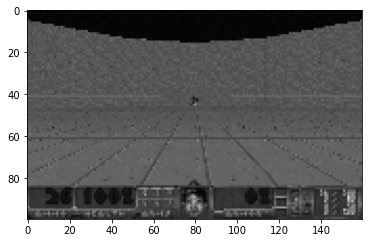

In [17]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [18]:
env.close()

# Setup Callback

In [19]:
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
  Attempting uninstall: torch
    Found existing installation: torch 1.10.2+cu102
    Uninstalling torch-1.10.2+cu102:
      Successfully uninstalled torch-1.10.2+cu102


ERROR: Could not install packages due to an OSError: [WinError 5] Adgang nægtet: 'C:\\Users\\Mathias\\anaconda3\\Lib\\site-packages\\~orch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



In [20]:
!pip install stable-baselines3[extra]

In [4]:
import os 
from stable_baselines3.common.callbacks import BaseCallback

In [5]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [1]:
CHECKPOINT_DIR = './train/train_defend'
LOG_DIR = './logs/log_defend'

In [6]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# Train Model

In [7]:
from stable_baselines3 import PPO

In [16]:
env = VizDoomGym()

In [17]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=4096)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [18]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_defend\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80.8     |
|    ep_rew_mean     | 0.46     |
| time/              |          |
|    fps             | 24       |
|    iterations      | 1        |
|    time_elapsed    | 169      |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 87          |
|    ep_rew_mean          | 0.787       |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 2           |
|    time_elapsed         | 442         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012068804 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.0268  

# Test the Model

In [ ]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
# Reload model from disc
model = PPO.load('./train/train_defend/best_model_100000')

In [ ]:
# Create rendered environment
env = VizDoomGym(render=True)

In [ ]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)

In [ ]:
mean_reward

In [ ]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    time.sleep(2)